## Laden der Text Daten 

In [1]:
import os, gzip
import pandas as pd
import numpy as np
import urllib.request

DATADIR = "data"

if not os.path.exists(DATADIR): 
    os.mkdir(DATADIR)

file_name = os.path.join(DATADIR, 'bundestags_parlamentsprotokolle.csv.gzip')
if not os.path.exists(file_name):
    url_data = 'https://www.dropbox.com/s/1nlbfehnrwwa2zj/bundestags_parlamentsprotokolle.csv.gzip?dl=1'
    urllib.request.urlretrieve(url_data, file_name)

df = pd.read_csv(gzip.open(file_name)).sample(frac=1)

alle_sprecher = df.sprecher.unique()
parteien = df.partei.unique()
partei_farben = {'cducsu':'black', 'linke':'purple', 'spd':'red', 'gruene':'green', 'fdp':'yellow'}

print("{} Reden wurden geladen".format(len(df)))

# Zeige einige Reden von Parteien
for party in np.unique(df['partei']):
    print("\n****************************\nBeispiele von Partei {}:\n****************************\n".format(party))
    for _, speech in df[df['partei']==party].sample(2).iterrows():
        print("\n*******************************\nSprecher {}:\n\n{}".format(speech['sprecher'], speech['text']))


43679 Reden wurden geladen

****************************
Beispiele von Partei cducsu:
****************************


*******************************
Sprecher Julia Bartz:

Sehr geehrte Frau Präsidentin! Liebe Kolleginnen und Kollegen! Am 24. September eröffnete unser Bundestagspräsident Norbert Lammert die Ausstellung "Operation Heimkehr". Im Paul-Löbe-Haus sind immer noch die Fotoaufnahmen von Soldatinnen und Soldaten zu sehen, die von Auslandseinsätzen zurückgekehrt sind. Hieraus zitiere ich Hauptfeldwebel Holger Roßmeier, der traumatisiert aus Afghanistan zurückkam:

Früher war ich jemand, der immer alles hinbekommen hat, einer, auf den man sich hundertprozentig verlassen konnte. Und plötzlich schaffte ich es nicht einmal mehr, morgens aufzustehen. Ich wollte aber nicht als Weichei dastehen. Deshalb habe ich jede Therapie zunächst abgelehnt.

Wir alle wissen: Auslandseinsätze können traumatisch sein. Die Erfahrungen, Erlebnisse und Eindrücke haben häufig langfristige Folgen, die tei

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import warnings

def train(texts, party):
    '''
    Eine Funktion, die gegeben Texte und Labels einen Klassifier trainiert
    '''
    stopwords = [w.strip() for w in open("data/stopwords.txt").readlines()]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Eine Machine Learning Pipeline um Bag-of-Words Vectors zu erstellen aus Texten
        text_clf = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)),
                            ('clf', SGDClassifier(loss='log', class_weight='balanced'))])
        # some hyperparameters
        parameters = {
            'vect__ngram_range': [(1, 1), (1, 2)],
            'vect__max_df': [0.8],
            'clf__alpha': (np.logspace(-6, -4, 2)).tolist()
        }
        # perform gridsearch to get the best regularizer
        clf = GridSearchCV(text_clf, parameters, cv=2, n_jobs=-1,verbose=4)
        clf.fit(texts, party)

    return clf


## Trainieren eines linearen Klassifiers

In [7]:
# Erst nehmen wir einige Daten beiseite, um das Model darauf spaeter testen zu koennen
train_data, test_data, train_labels, test_labels = train_test_split(df['text'], df['partei'], test_size=0.5)

# Jetzt trainieren wir den Klassifier
clf = train(train_data, train_labels)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2) ....
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.4787545787545788, total=  10.1s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1) ...
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.48319443172451687, total=  10.6s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1) ...
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.489010989010989, total=  12.1s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2) ...
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.5075556369630918, total=  11.9s


[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   36.7s remaining:   36.7s


[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2) ...
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.4967948717948718, total=  28.2s
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5035259639161095, total=  28.5s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.48635531135531135, total=  20.5s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.4922611960802271, total=  19.7s


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.0min finished


Best parameters set found on development set:

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

Grid scores on development set:

0.481 (+/-0.001) for {'clf__alpha': 1e-06, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 1)}
0.500 (+/-0.002) for {'clf__alpha': 1e-06, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 2)}
0.498 (+/-0.005) for {'clf__alpha': 0.0001, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 1)}
0.489 (+/-0.001) for {'clf__alpha': 0.0001, 'vect__max_df': 0.8, 'vect__ngram_range': (1, 2)}



# Vorhersage auf Trainings Daten

In [8]:
train_predictions = clf.predict(train_data)
report = classification_report(train_predictions, train_labels)
print(report)

             precision    recall  f1-score   support

     cducsu       1.00      1.00      1.00      7958
        fdp       1.00      1.00      1.00      1694
     gruene       1.00      1.00      1.00      3142
      linke       1.00      1.00      1.00      3100
        spd       1.00      1.00      1.00      5945

avg / total       1.00      1.00      1.00     21839



# Vorhersage auf Test Daten

In [9]:
test_predictions = clf.predict(test_data)
report = classification_report(test_predictions, test_labels)
print(report)

             precision    recall  f1-score   support

     cducsu       0.80      0.58      0.67     11130
        fdp       0.20      0.49      0.29       691
     gruene       0.26      0.50      0.35      1634
      linke       0.46      0.63      0.53      2167
        spd       0.51      0.49      0.50      6218

avg / total       0.62      0.55      0.57     21840



## Confusion Matrix

In [10]:
print(confusion_matrix(test_labels, test_predictions))

[[6457  153  157  168 1143]
 [ 964  342   34   49  287]
 [ 891   54  822  327 1032]
 [ 560   36  316 1369  719]
 [2258  106  305  254 3037]]


## Download eines Zeitungsartikels

In [11]:
import urllib.request
from readability.readability import Document

url = "http://www.spiegel.de/politik/ausland/muss-deutschland-jetzt-milliarden-an-polen-zahlen-a-1167144.html"
html = urllib.request.urlopen(url).read()
readable_article = Document(html).summary()
readable_title = Document(html).short_title()


## Klassifizierung des Zeitungsartikels

Zeitungsartikel: Muss Deutschland jetzt Milliarden an Polen zahlen?


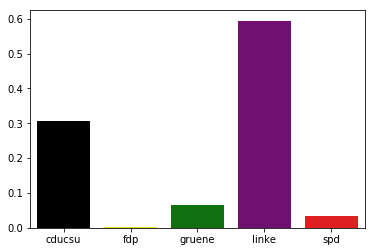

In [16]:
prediction = clf.predict_proba([readable_article])

print("Zeitungsartikel: {}".format(readable_title))

import seaborn as sns
%matplotlib inline
sns.barplot(clf.best_estimator_.steps[1][1].classes_, prediction.flatten(), palette=[partei_farben[p] for p in clf.classes_])

In [18]:
bow_vectors = clf.best_estimator_.steps[0][1].transform(df.text)
idx2words = {k:v for v,k in clf.best_estimator_.steps[0][1].vocabulary_.items()}
for party in np.unique(df['partei']):
    this_party = (df['partei'] == party).values * 2 - 1
    word_covariance = bow_vectors.T.dot(this_party).argsort()
    top_words = [idx2words[widx] for widx in word_covariance[-20:][::-1]]
    print("*********************\nPartei {} benutzt haeufig:\n{}".format(party, ", ".join(top_words)))

*********************
Partei cducsu benutzt haeufig:
christlich, wettbewerbsfähigkeit, liberale koalition, christlich liberale, kernenergie, christlich liberalen, liberalen koalition, asylbewerber, währung, christen, richtigen, flüchtlingskrise, ukraine, wolfgang schäuble, stabilität, dankeschön, wohlstand, eigenverantwortung, russlands, vernetzten
*********************
Partei fdp benutzt haeufig:
fdp bundestagsfraktion, fdp fraktion, sicht fdp, liberaler, zuwanderungssteuerung, energieeffizienzstandards, lehnt fdp, freien demokraten, liberaler sicht, sharma, bafög modernisierung, hefen, unimog, verbrechen deutschen, schuldenbergen kinder, verwaltungsmodernisierung, justice gesetz, fdp begrüßt, kollege schneider, waffensteuer
*********************
Partei gruene benutzt haeufig:
garantierente, klimakrise, leiharbeitskräfte, finanzaufsichtsbehörde, tisa, immigranten, staaten regelung, grüner sicht, einwanderinnen, wehrbericht, dualplus, mindestniveau, finanzplanperiode, sozialen kosten, 

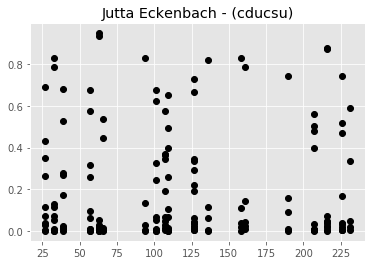

In [36]:
import matplotlib
matplotlib.style.use('ggplot')
import pylab as plt

# Wir betrachten nur die letzte Legislaturperiode
wahlperiode = 18

for sprecher in ['Jutta Eckenbach']:

    traindf = df[(df['sprecher']!=sprecher)]
    testdf = df[(df['sprecher']==sprecher) & (df['wahlperiode']==wahlperiode)].sort_values(['sitzung'])

    if (len(traindf) > 10) and (len(testdf) > 10):
        partei = testdf.partei.values[0]
        tmpclf = clf.best_estimator_.copy().fit(traindf.text, traindf.partei)
        predictions = tmpclf.predict_proba(testdf.text)
        plt.cla()
        for partei_idx in range(predictions.shape[-1]):
            color = partei_farben[clf.partei_idx]]
            plt.plot(testdf.sitzung, predictions[:, partei_idx],"o",color=color)
            plt.title("{} - ({})".format(sprecher,partei))
            plt.savefig(sprecher + ".pdf")


In [31]:
df[df.wahlperiode==18]

,Unnamed: 0,sitzung,wahlperiode,sprecher,text,partei
43304,43304,241,18,Martin Dörmann,denn das nutzt in der Tat auch uns. – Das ist ...,spd
36783,36783,152,18,Omid Nouripour,Gleichzeitig dürfen wir das politische Umfeld ...,gruene
43439,43439,243,18,Wolfgang Gunkel,Aufgrund der mir zur Verfügung stehenden Redez...,spd
34213,34213,124,18,Dr. Hendrik Hoppenstedt,"Das sage ich deswegen, weil wir hier eine ganz...",cducsu
34154,34154,123,18,Britta Haßelmann,"Vielen Dank, Frau Präsidentin. – Frau Staatsse...",gruene
36419,36419,148,18,Niels Annen,Vielen Dank. – Frau Präsidentin! Meine sehr ve...,spd
29999,29999,73,18,Julia Bartz,Das Gegenteil ist nun der Fall. Zudem ignorier...,cducsu
38428,38428,172,18,Andreas Jung,"Sie werden dadurch Schub bekommen, um tatsächl...",cducsu
34669,34669,128,18,Dr. Bernd Fabritius,Zudem ist sie Nachbereiterin sowohl nach Erfol...,cducsu
39218,39218,180,18,Matthäus Strebl,"Meine sehr verehrten Damen und Herren, besonde...",cducsu


In [34]:
testdf.partei.values[0]

'cducsu'